In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
# set plot size to fill the width of the page
plt.rcParams["figure.figsize"] = (10, 5)
import copy

# Model definition

In [2]:
# simple multi_layer perceptron with relu nonlinearity with pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)
        self.relu1 = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0), requires_grad=False), inplace=True)
        self.relu2 = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0), requires_grad=False), inplace=True)

    def forward(self, x):
        x = self.fc1(x)
        # x = self.relu1(x)
        # x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)            
        return x

/home/soheil/miniconda3/envs/lc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
model = Net(1, 500, 1)

In [16]:
model

Net(
  (fc1): Linear(in_features=1, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
  (relu1): LeakyReLU(negative_slope=0, inplace=True)
  (relu2): LeakyReLU(negative_slope=0, inplace=True)
)

# Sample dataset

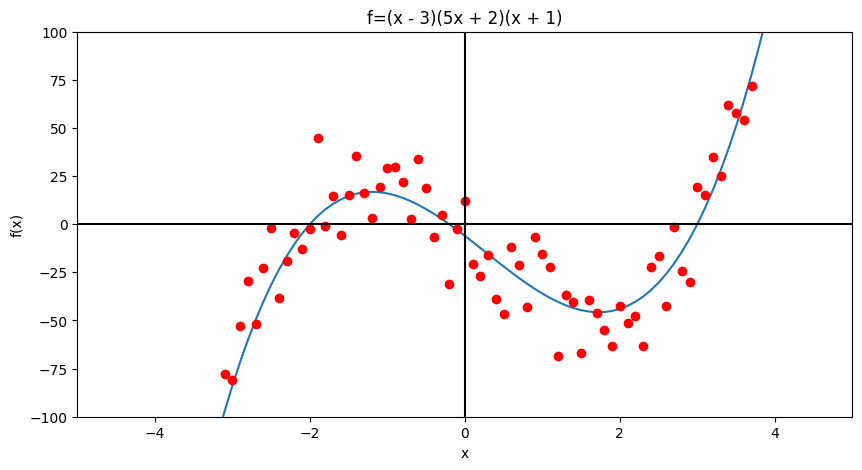

In [5]:
# plot function f=(x - 3)*(x + 2)*(x + 1)
x = np.arange(-5, 5, 0.1)
noise = np.random.normal(0, 15, x.shape)
y = (x - 3)*(x + 2)*(5*x + 1)
plt.plot(x, y)
plt.plot(x, y + noise, 'ro')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f=(x - 3)(5x + 2)(x + 1)')
plt.show()


In [18]:
# train model on x and y + noise
# convert to torch tensors
# broadcast x to 100 x 1 tensor

X = torch.from_numpy(x.reshape(-1,1)).float()
Y = torch.from_numpy((y + noise).reshape(-1,1)).float()

print(X.shape)
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
wd = 0.000

losses = []

# train model
for epoch in tqdm.tqdm(range(50000)):
    # forward pass
    y_pred = model(X)
    # compute loss
    loss = criterion(y_pred, Y) #+ (torch.norm(model.fc1.weight, 1) + torch.norm(model.fc2.weight, 1) + torch.norm(model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

torch.Size([100, 1])


  0%|          | 84/50000 [00:00<00:59, 836.80it/s]

epoch 0, loss 142.85475158691406


  2%|▏         | 1138/50000 [00:01<00:46, 1040.70it/s]

epoch 1000, loss 142.74072265625


  4%|▍         | 2193/50000 [00:02<00:45, 1044.06it/s]

epoch 2000, loss 142.60153198242188


  6%|▋         | 3144/50000 [00:03<00:44, 1044.42it/s]

epoch 3000, loss 142.43772888183594


  8%|▊         | 4200/50000 [00:04<00:43, 1043.62it/s]

epoch 4000, loss 142.2727813720703


 10%|█         | 5148/50000 [00:04<00:43, 1032.29it/s]

epoch 5000, loss 142.1297149658203


 12%|█▏        | 6191/50000 [00:05<00:42, 1028.39it/s]

epoch 6000, loss 141.95242309570312


 14%|█▍        | 7123/50000 [00:06<00:42, 1008.91it/s]

epoch 7000, loss 141.79791259765625


 16%|█▋        | 8162/50000 [00:07<00:40, 1021.13it/s]

epoch 8000, loss 141.64430236816406


 18%|█▊        | 9199/50000 [00:08<00:39, 1029.94it/s]

epoch 9000, loss 141.4906768798828


 20%|██        | 10144/50000 [00:09<00:38, 1027.35it/s]

epoch 10000, loss 141.3372802734375


 22%|██▏       | 11196/50000 [00:10<00:37, 1027.23it/s]

epoch 11000, loss 141.18260192871094


 24%|██▍       | 12138/50000 [00:11<00:37, 1017.58it/s]

epoch 12000, loss 141.03973388671875


 26%|██▋       | 13188/50000 [00:12<00:35, 1040.76it/s]

epoch 13000, loss 140.88282775878906


 28%|██▊       | 14133/50000 [00:13<00:34, 1040.61it/s]

epoch 14000, loss 140.72698974609375


 30%|███       | 15183/50000 [00:14<00:33, 1040.70it/s]

epoch 15000, loss 140.61093139648438


 32%|███▏      | 16128/50000 [00:15<00:32, 1040.83it/s]

epoch 16000, loss 140.44155883789062


 34%|███▍      | 17179/50000 [00:16<00:31, 1040.07it/s]

epoch 17000, loss 140.2921905517578


 36%|███▌      | 18124/50000 [00:17<00:30, 1040.95it/s]

epoch 18000, loss 140.1518096923828


 38%|███▊      | 19175/50000 [00:18<00:29, 1042.00it/s]

epoch 19000, loss 140.00880432128906


 40%|████      | 20121/50000 [00:19<00:28, 1040.67it/s]

epoch 20000, loss 139.86703491210938


 42%|████▏     | 21171/50000 [00:20<00:27, 1040.44it/s]

epoch 21000, loss 139.72393798828125


 44%|████▍     | 22116/50000 [00:21<00:26, 1039.41it/s]

epoch 22000, loss 139.5935516357422


 46%|████▋     | 23166/50000 [00:22<00:25, 1039.75it/s]

epoch 23000, loss 139.4477081298828


 48%|████▊     | 24111/50000 [00:23<00:24, 1038.84it/s]

epoch 24000, loss 139.31996154785156


 50%|█████     | 25162/50000 [00:24<00:23, 1041.14it/s]

epoch 25000, loss 139.17164611816406


 52%|█████▏    | 26107/50000 [00:25<00:22, 1042.05it/s]

epoch 26000, loss 139.03843688964844


 54%|█████▍    | 27158/50000 [00:26<00:21, 1040.10it/s]

epoch 27000, loss 138.9071502685547


 56%|█████▋    | 28208/50000 [00:27<00:20, 1038.75it/s]

epoch 28000, loss 138.7709503173828


 58%|█████▊    | 29153/50000 [00:28<00:20, 1040.89it/s]

epoch 29000, loss 138.64048767089844


 60%|██████    | 30203/50000 [00:29<00:19, 1040.65it/s]

epoch 30000, loss 138.50404357910156


 62%|██████▏   | 31149/50000 [00:29<00:18, 1040.06it/s]

epoch 31000, loss 138.37875366210938


 64%|██████▍   | 32199/50000 [00:30<00:17, 1038.65it/s]

epoch 32000, loss 138.23187255859375


 66%|██████▋   | 33143/50000 [00:31<00:16, 1038.90it/s]

epoch 33000, loss 138.09414672851562


 68%|██████▊   | 34191/50000 [00:32<00:15, 1031.18it/s]

epoch 34000, loss 137.9532470703125


 70%|███████   | 35125/50000 [00:33<00:14, 1027.34it/s]

epoch 35000, loss 137.79129028320312


 72%|███████▏  | 36163/50000 [00:34<00:13, 1026.62it/s]

epoch 36000, loss 137.655517578125


 74%|███████▍  | 37195/50000 [00:35<00:12, 1007.81it/s]

epoch 37000, loss 137.5164337158203


 76%|███████▋  | 38127/50000 [00:36<00:11, 1026.16it/s]

epoch 38000, loss 137.39834594726562


 78%|███████▊  | 39166/50000 [00:37<00:10, 1028.67it/s]

epoch 39000, loss 137.2715606689453


 80%|████████  | 40142/50000 [00:38<00:10, 930.49it/s] 

epoch 40000, loss 137.15219116210938


 82%|████████▏ | 41173/50000 [00:39<00:08, 1022.79it/s]

epoch 41000, loss 137.0353240966797


 84%|████████▍ | 42106/50000 [00:40<00:07, 1027.82it/s]

epoch 42000, loss 136.92823791503906


 86%|████████▋ | 43142/50000 [00:41<00:06, 1020.25it/s]

epoch 43000, loss 136.83807373046875


 88%|████████▊ | 44178/50000 [00:42<00:05, 1024.40it/s]

epoch 44000, loss 136.78829956054688


 90%|█████████ | 45107/50000 [00:43<00:04, 1012.75it/s]

epoch 45000, loss 136.63909912109375


 92%|█████████▏| 46144/50000 [00:44<00:03, 1026.06it/s]

epoch 46000, loss 136.5402374267578


 94%|█████████▍| 47182/50000 [00:45<00:02, 1027.24it/s]

epoch 47000, loss 136.44393920898438


 96%|█████████▌| 48116/50000 [00:46<00:01, 1027.53it/s]

epoch 48000, loss 136.35548400878906


 98%|█████████▊| 49155/50000 [00:47<00:00, 1027.06it/s]

epoch 49000, loss 136.26504516601562


100%|██████████| 50000/50000 [00:48<00:00, 1031.55it/s]


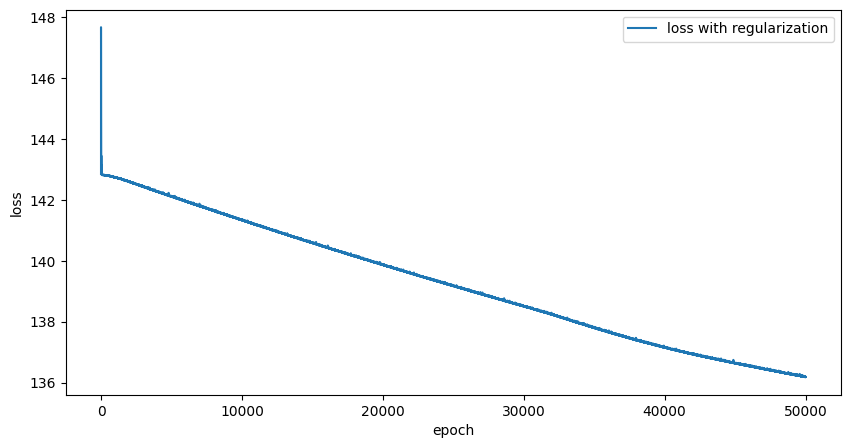

In [19]:
# plot loss
plt.plot(losses, label='loss with regularization')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

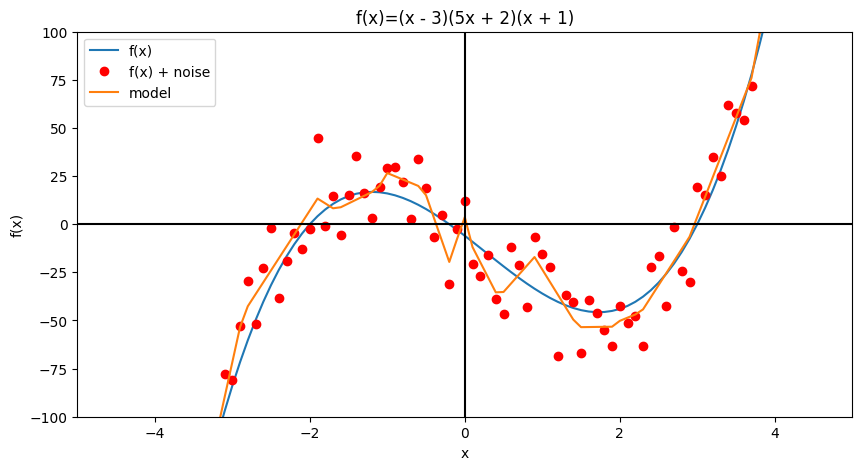

In [21]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

# change model relu slope to 0.5 without finetuning

In [22]:
collapsed_model = copy.deepcopy(model)

In [23]:
# model.backbone.classifier._modules[_number] = new_module
collapsed_model._modules['relu2'] = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0.5), requires_grad=False), inplace=True)

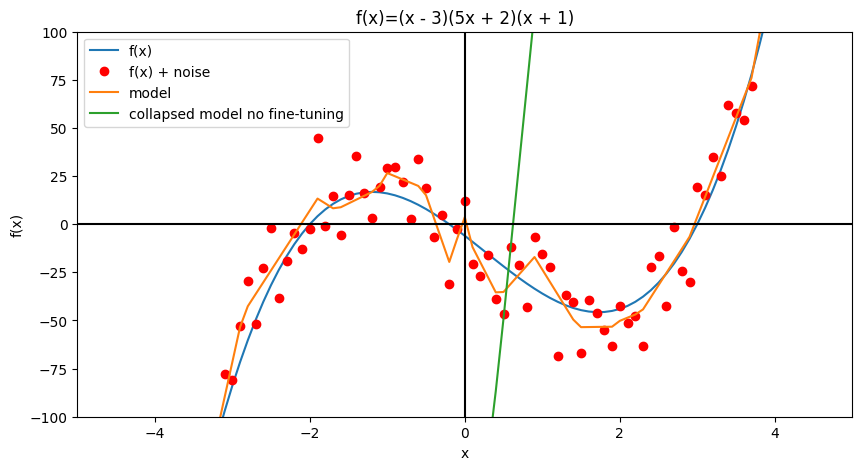

In [24]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed model no fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

  8%|▊         | 85/1000 [00:00<00:02, 429.60it/s]

epoch 0, loss 1100144.625


100%|██████████| 1000/1000 [00:02<00:00, 499.96it/s]


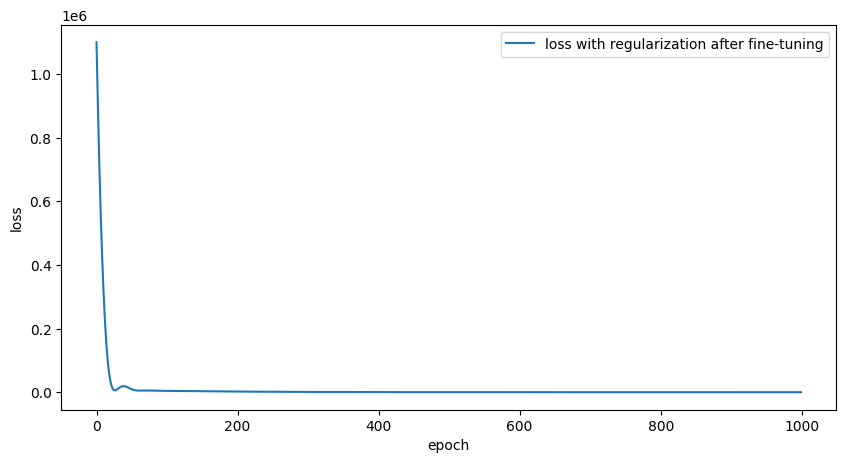

In [25]:
# finetuen collapsed model
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(collapsed_model.parameters(), lr=0.01)
wd = 0.000

losses_finetune = []

# train model
for epoch in tqdm.tqdm(range(1000)):
    # forward pass
    y_pred = collapsed_model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(collapsed_model.fc1.weight, 1) + torch.norm(collapsed_model.fc2.weight, 1) + torch.norm(collapsed_model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses_finetune.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

# plot loss
plt.plot(losses_finetune, label='loss with regularization after fine-tuning')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

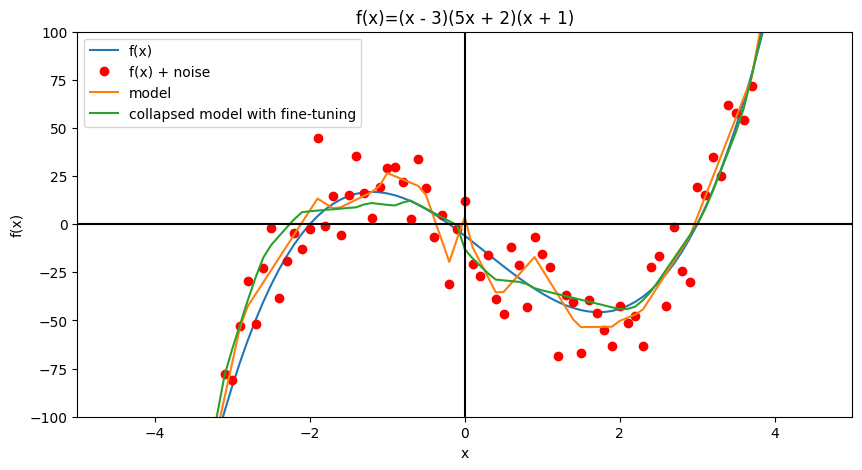

In [26]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed model with fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

In [27]:
almost_fully_collapsed_model = copy.deepcopy(model)
almost_fully_collapsed_model._modules['relu2'] = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(.8), requires_grad=False), inplace=True)

  1%|▏         | 70/5000 [00:00<00:14, 349.76it/s]

epoch 0, loss 2815973.0


 21%|██▏       | 1070/5000 [00:02<00:07, 530.64it/s]

epoch 1000, loss 4334.544921875


 42%|████▏     | 2107/5000 [00:04<00:05, 534.93it/s]

epoch 2000, loss 1499.2718505859375


 62%|██████▏   | 3094/5000 [00:06<00:03, 537.41it/s]

epoch 3000, loss 782.1520385742188


 82%|████████▏ | 4075/5000 [00:07<00:01, 537.48it/s]

epoch 4000, loss 467.8794860839844


100%|██████████| 5000/5000 [00:09<00:00, 519.19it/s]


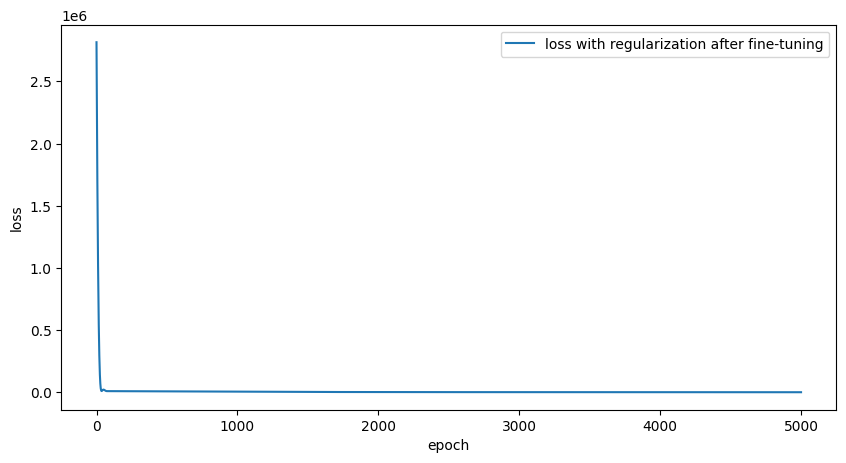

In [28]:
# finetuen collapsed model
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(almost_fully_collapsed_model.parameters(), lr=0.01)
wd = 0.000

losses_finetune = []

# train model
for epoch in tqdm.tqdm(range(5000)):
    # forward pass
    y_pred = almost_fully_collapsed_model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(almost_fully_collapsed_model.fc1.weight, 1) + torch.norm(almost_fully_collapsed_model.fc2.weight, 1) + torch.norm(almost_fully_collapsed_model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses_finetune.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

# plot loss
plt.plot(losses_finetune, label='loss with regularization after fine-tuning')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

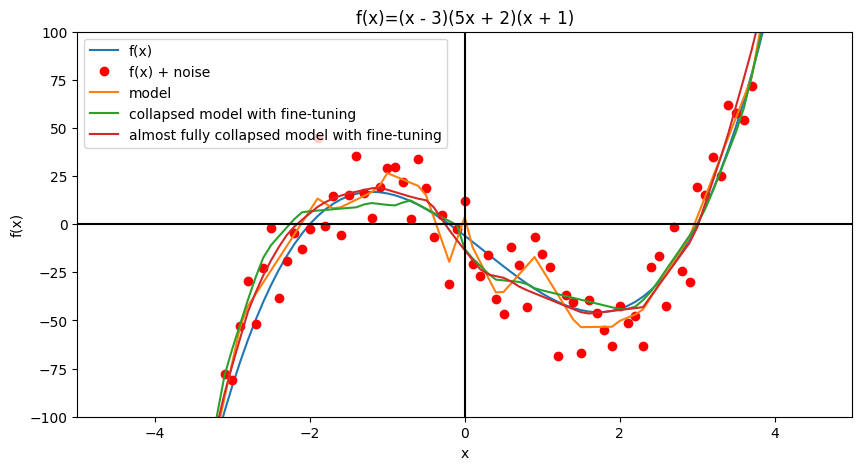

In [29]:
#plot model predictions
plt.plot(x, y, label='f(x)')
plt.plot(x, y + noise, 'ro', label='f(x) + noise')
plt.plot(x, model(X).detach().numpy(), label='model')
plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed model with fine-tuning')
plt.plot(x, almost_fully_collapsed_model(X).detach().numpy(), label='almost fully collapsed model with fine-tuning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(-5, 5)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
plt.legend()
plt.show()

In [61]:
fully_collapsed_model = copy.deepcopy(almost_fully_collapsed_model)
fully_collapsed_model._modules['relu2'] = nn.LeakyReLU(negative_slope=nn.Parameter(torch.tensor(0.98), requires_grad=False), inplace=True)

  1%|          | 81/10000 [00:00<00:24, 398.78it/s]

epoch 0, loss 203263.0625


 11%|█         | 1076/10000 [00:02<00:20, 444.08it/s]

epoch 1000, loss 8243.16796875


 21%|██        | 2073/10000 [00:04<00:17, 444.09it/s]

epoch 2000, loss 7794.947265625


 31%|███       | 3070/10000 [00:06<00:15, 446.32it/s]

epoch 3000, loss 7225.25927734375


 41%|████      | 4071/10000 [00:09<00:13, 445.69it/s]

epoch 4000, loss 6478.927734375


 51%|█████     | 5070/10000 [00:11<00:11, 443.68it/s]

epoch 5000, loss 5616.791015625


 61%|██████    | 6066/10000 [00:13<00:08, 443.37it/s]

epoch 6000, loss 4859.63232421875


 71%|███████   | 7062/10000 [00:15<00:06, 445.38it/s]

epoch 7000, loss 4269.0517578125


 81%|████████  | 8055/10000 [00:18<00:04, 444.75it/s]

epoch 8000, loss 3764.051513671875


 90%|█████████ | 9050/10000 [00:20<00:02, 441.23it/s]

epoch 9000, loss 3418.1318359375


100%|██████████| 10000/10000 [00:22<00:00, 443.86it/s]


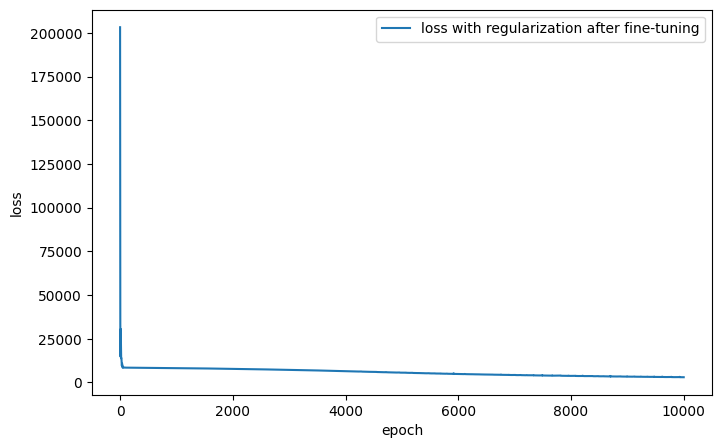

In [62]:
# finetuen collapsed model
# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(fully_collapsed_model.parameters(), lr=0.01)
wd = 0.000

losses_finetune = []

# train model
for epoch in tqdm.tqdm(range(10000)):
    # forward pass
    y_pred = fully_collapsed_model(X)
    # compute loss
    loss = criterion(y_pred, Y) + (torch.norm(fully_collapsed_model.fc1.weight, 1) + torch.norm(fully_collapsed_model.fc2.weight, 1) + torch.norm(fully_collapsed_model.fc3.weight, 1)) * wd
    # zero gradients
    optimizer.zero_grad()
    # backward pass
    loss.backward()
    losses_finetune.append(loss.item())
    # update weights
    optimizer.step()
    if epoch % 1000 == 0:
        tqdm.tqdm.write('epoch {}, loss {}'.format(epoch, loss.item()))

# plot loss
plt.plot(losses_finetune, label='loss with regularization after fine-tuning')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

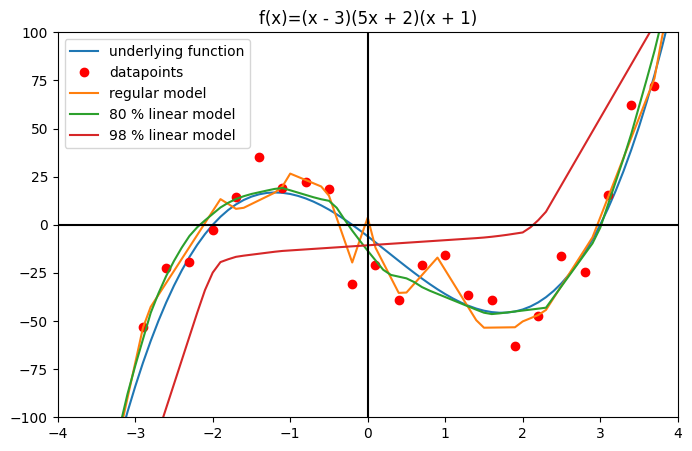

In [64]:
#plot model predictions
plt.plot(x, y, label='underlying function')
plt.plot(x[::3], y[::3] + noise[::3], 'ro', label='datapoints')
plt.plot(x, model(X).detach().numpy(), label='regular model')
# plt.plot(x, collapsed_model(X).detach().numpy(), label='collapsed 50% model with fine-tuning')
plt.plot(x, almost_fully_collapsed_model(X).detach().numpy(), label='80 % linear model')
plt.plot(x, fully_collapsed_model(X).detach().numpy(), label='98 % linear model')
# plt.xlabel('x')
# plt.ylabel('f(x)')
plt.xlim(-4, 4)
plt.ylim(-100, 100)
# baseline
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('f(x)=(x - 3)(5x + 2)(x + 1)')
# set figure size to 8x8
plt.rcParams["figure.figsize"] = (8, 5)

plt.legend()
plt.show()